In [0]:
import torch
!pip install pyro-ppl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from torch.autograd import Variable
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine

     |████████████████████████████████| 378kB 4.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0


(array([16., 25., 25., 21., 10., 16., 14.,  8., 16., 13.,  9., 16.,  8.,
         7., 10., 14.,  9.,  6.,  7.,  8.,  7.,  6.,  5.,  1.,  5.,  6.,
         2.,  5.,  5.,  3.,  3.,  3.,  4.,  2.,  1.,  0.,  0.,  0.,  2.,
         1.]),
 array([  0.    ,   6.7325,  13.465 ,  20.1975,  26.93  ,  33.6625,
         40.395 ,  47.1275,  53.86  ,  60.5925,  67.325 ,  74.0575,
         80.79  ,  87.5225,  94.255 , 100.9875, 107.72  , 114.4525,
        121.185 , 127.9175, 134.65  , 141.3825, 148.115 , 154.8475,
        161.58  , 168.3125, 175.045 , 181.7775, 188.51  , 195.2425,
        201.975 , 208.7075, 215.44  , 222.1725, 228.905 , 235.6375,
        242.37  , 249.1025, 255.835 , 262.5675, 269.3   ]),
 <a list of 40 Patch objects>)

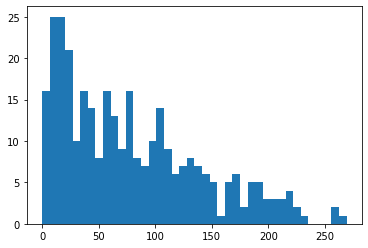

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())

plt.hist(df['sunspot.year'].values, bins=40)

In [0]:
import time

N = df.shape[0]

cluster_rates = {}

data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
def crp_model(data):
    alpha0 = pyro.sample('alpha', dist.Gamma(2, 0.5))
    # alpha0 = 2.
    global cluster_rates
    # cluster_rates = {}  
    crp_counts = []  # build this incrementally
    for i in range(len(data)):
        # sample from a CRP
        weights = torch.tensor(crp_counts + [alpha0], dtype=torch.float32) 
        weights /= weights.sum()
        crp_weights = pyro.param("weights_{}".format(i), Variable(weights), constraint=constraints.simplex)
        # print (crp_weights)

        zi = pyro.sample("z_{}".format(i), dist.Categorical(crp_weights))
        zi = zi.item() 

        if zi >= len(crp_counts):
            crp_counts.append(1)  # sit at a new table
        else:
            crp_counts[zi] += 1  # sit at an existing table

        if zi not in cluster_rates.keys():
            cluster_rates[zi] = pyro.sample("lambda_{}".format(zi), dist.Uniform(0, 200))
        lambda_i = cluster_rates[zi]
        pyro.sample("obs_{}".format(i), dist.Poisson(lambda_i), obs=data[i])

# guide = AutoDiagonalNormal(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))
# guide = AutoDelta(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))
# guide = AutoIAFNormal(poutine.block(crp_model, expose=['lambda_{}'.format(i) for i in range(30)], hide=['z_{}'.format(i) for i in range(len(data))] + ['weights_{}'.format(i) for i in range(len(data) - 1)]))
# guide = AutoIAFNormal(poutine.block(crp_model, expose=['weights_{}'.format(i) for i in range(len(data))] + ['lambda_{}'.format(i) for i in range(30)]))
guide = AutoIAFNormal(poutine.block(crp_model, expose=['weights_318', 'lambda_0', 'lambda_1', 'lambda_2'])) # hidden dim?


# guide = AutoContinuous(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))] + ['weights_{}'.format(i) for i in range(len(data) - 1)]))

# def guide(data):
#     alpha_q = pyro.sample('alpha_q', dist.Gamma(2, 0.5))
#     cluster_rates_q = {}  # sample this lazily
#     crp_counts_q = []  # build this incrementally
#     for i in range(len(data)):
#         # sample from a CRP
#         weights_q = torch.tensor(crp_counts_q + [alpha_q], dtype=torch.float32) 
#         weights_q /= weights_q.sum()
#         crp_weights_q = pyro.param("weights_q_{}".format(i), Variable(weights_q), constraint=constraints.simplex)

#         zi_q = pyro.sample("z_q_{}".format(i), dist.Categorical(crp_weights_q))
#         zi_q = zi_q.item() 

#         if zi_q >= len(crp_counts_q):
#             crp_counts_q.append(1)  # sit at a new table
#         else:
#             crp_counts_q[zi_q] += 1  # sit at an existing table

#         if zi_q not in cluster_rates_q.keys():
#             cluster_rates_q[zi_q] = pyro.sample("lambda_q_{}".format(zi_q), dist.Uniform(0, 200))
#         lambda_i_q = cluster_rates_q[zi_q]
#         pyro.sample("obs_q_{}".format(i), dist.Poisson(lambda_i_q), obs=data[i])


optim = Adam({"lr": 0.05})
svi = SVI(crp_model, guide, optim, loss=TraceEnum_ELBO(), num_samples=1000)

def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(500)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

print (cluster_rates)


[iteration 0001] loss: 37.0765
weights_0 tensor([1.], grad_fn=<DivBackward0>)
weights_1 tensor([0.7327, 0.2673], grad_fn=<DivBackward0>)
weights_2 tensor([0.9825, 0.0175], grad_fn=<DivBackward0>)
weights_3 tensor([0.0641, 0.0743, 0.8616], grad_fn=<DivBackward0>)
weights_4 tensor([0.8525, 0.0322, 0.1153], grad_fn=<DivBackward0>)
weights_5 tensor([0.4678, 0.0541, 0.4080, 0.0700], grad_fn=<DivBackward0>)
weights_6 tensor([0.8660, 0.1000, 0.0219, 0.0121], grad_fn=<DivBackward0>)
weights_7 tensor([0.6393, 0.0782, 0.0475, 0.1423, 0.0928], grad_fn=<DivBackward0>)
weights_8 tensor([0.0353, 0.0129, 0.0570, 0.0586, 0.8362], grad_fn=<DivBackward0>)
weights_9 tensor([0.0408, 0.3981, 0.1368, 0.0877, 0.1066, 0.2300],
       grad_fn=<DivBackward0>)
weights_10 tensor([0.0868, 0.0894, 0.4325, 0.0783, 0.0307, 0.2822],
       grad_fn=<DivBackward0>)
weights_11 tensor([0.0699, 0.0091, 0.0082, 0.6824, 0.0306, 0.1997],
       grad_fn=<DivBackward0>)
weights_12 tensor([0.1379, 0.0361, 0.2231, 0.1269, 0.0283,

In [0]:
print (len(pyro.param('weights_318').detach().numpy()))
print (len(cluster_rates.keys()))

print (list(cluster_rates.values()))

19
19
[tensor(96.8907), tensor(79.5952), tensor(109.9739), tensor(177.5575), tensor(124.9326), tensor(194.4476), tensor(76.7483), tensor(89.0180), tensor(38.5438), tensor(142.1414), tensor(114.6843), tensor(196.0278), tensor(71.2031), tensor(162.1087), tensor(18.0207), tensor(174.8316), tensor(84.6450), tensor(49.4851), tensor(76.9358)]


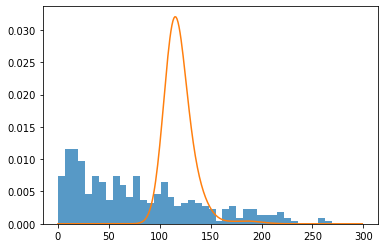

In [0]:
# print(pyro.get_param_store())

from scipy.stats import poisson

X = np.arange(0, 300)

# print (pyro.param('weights_318').detach().numpy())
# print ([pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(10)])

def mop(X):
  weights = pyro.param('weights_318').detach().numpy()
  # rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(len(weights) - 1)]
  rates = [i.detach().item() for i in list(cluster_rates.values())]
  return sum( [weights[i] * poisson.pmf(X, rates[i]) for i in range(len(weights))] )


Y = mop(X)
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()
